<a href="https://colab.research.google.com/github/Nakiyah24/ExplainableAI_Assignments/blob/main/Assignment6/Assignment6_PFI_PartII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignemnt 3
## Nakiyah Dhariwala

### Permutation Importance (PFI) — Code Demo
- Audience: Students new to Explainable AI methods

The purpose of this demo is to implement Permutation Feature Importance (PFI) to understand which features a trained model relies on by measuring how its performance changes when we randomly shuffle each feature.

PFI provides a global explanation of a model — it tells us, on average, which features are most influential across the entire dataset, rather than for any single prediction. In other words, it moves us from “How well does my model perform?” to “What features make it perform well?”

For this demonstration, I’ll use the **California Housing dataset** from sklearn, which contains information about different districts in California (e.g., median income, house age, average rooms, population, and geographic location).
The goal is to predict the median house value for each district.

I chose the Random Forest Regressor for this task because:
- It captures non-linear relationships and feature interactions automatically.
- It provides strong baseline performance with minimal tuning.
- Lastly, it’s a black-box model, which makes it ideal for me to demonstrate why we need interpretability methods like PFI

Below, we’ll train our Random Forest model, measure its baseline performance, and then apply PFI to reveal which features it truly relies on.

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

# Import the dataset
from sklearn.datasets import fetch_california_housing

In [2]:
# Load dataset as Pandas Dataframe
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

# Code generated by ChatGPT-5 on 10/18/2025

In [3]:
# Basic inspection
print("Shape:", X.shape)
X.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
# Creating a train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Evaluate baseline - I am using R-squared as the evaluation metric
pred = rf.predict(X_test)
r2_base = r2_score(y_test, pred)
print(f"Baseline Test R-squared: {r2_base:.3f}")

Baseline Test R-squared: 0.807


Now that we’ve trained our Random Forest model, we can see that its baseline R-sqyre score is 0.808 (≈ 80.8%).
This tells us that the model explains about 80% of the variation in median house values across California. But raw performance alone doesn’t tell us which features were responsible for that 80%. For instance — did the model rely more on Median Income or Average Number of Rooms?

This is where Permutation Feature Importance (PFI) comes in.


The idea behind Permutation Importance is simple but powerful:
- Shuffle one feature’s values in the test set (breaking its relationship with the target).
- Recalculate the model’s performance (R-squared in our case).
- Measure how much the R-square score drops compared to the baseline.


If shuffling a feature causes a big drop, that feature was important. However, if the R-square barely changes, the feature didn’t contribute much. Just for simplicity, the code snippet below will show how much the performance change sby shuffling ONLY the Median Income once:

In [6]:
# Select Median Income feaure
feature = "MedInc"
shuffled = X_test.copy()
shuffled[feature] = np.random.permutation(shuffled[feature])

r2_shuffled = r2_score(y_test, rf.predict(shuffled))
print(f"R-squared baseline: {r2_base:.3f}")
print(f"R-squared after shuffling {feature}: {r2_shuffled:.3f}")
print(f"Drop: {r2_base - r2_shuffled:.3f}")

# The code for generating this table was taken from Chatgpt-5 on 10/19/2025

R-squared baseline: 0.807
R-squared after shuffling MedInc: 0.033
Drop: 0.774


When we shuffled the Median Income (MedInc) feature, the model’s R-squared score dropped from 0.806 to 0.102, which is a massive 0.705 decrease.

This tells us that Median Income is an extremely influential feature in predicting house values. Once we removed the income signal by shuffling its features, the model lost almost all of its predictive power.

However doing this manually, one column at a time, would be slow and inconsistent.
Hence, I am going to make use of scikit-learn’s built-in permutation_importance() function, which automates the entire process wherein:

- It shuffles each feature one at a time on the test set,
- Recalculates performance (R-squared in our case),
- Repeats the process multiple times to reduce randomness (I have chosen 20 repetitions),
- And returns the average drop in R-squared for every feature.

This gives us a complete and reliable ranking of which variables the model depends on most — not just “MedInc” (i.e. Median Income) but all predictors together.

In [7]:
# Evaluate feature importance via permutation (20 repeats = stable)
pi = permutation_importance(
    rf, X_test, y_test, n_repeats=20, random_state=42, scoring="r2"
)

In [8]:
baseline = r2_base  # baseline

drop_table = pd.DataFrame(
    {
        "Feature": X_test.columns,
        "Baseline R-squared": baseline,
        "R-squared (mean, shuffled)": baseline - pi.importances_mean,
        "Drop in R-squared": pi.importances_mean,
        "Drop Std": pi.importances_std,
    }
).sort_values("Drop in R-squared", ascending=False)

print(drop_table.round(4))

# The code for generating this table was taken from Chatgpt-5 on 10/19/2025

      Feature  Baseline R-squared  R-squared (mean, shuffled)  \
0      MedInc              0.8066                      0.0698   
6    Latitude              0.8066                      0.3623   
7   Longitude              0.8066                      0.4723   
5    AveOccup              0.8066                      0.6053   
1    HouseAge              0.8066                      0.7363   
2    AveRooms              0.8066                      0.7791   
3   AveBedrms              0.8066                      0.7974   
4  Population              0.8066                      0.7982   

   Drop in R-squared  Drop Std  
0             0.7368    0.0169  
6             0.4443    0.0100  
7             0.3343    0.0065  
5             0.2013    0.0086  
1             0.0703    0.0041  
2             0.0275    0.0016  
3             0.0092    0.0013  
4             0.0084    0.0009  


The table shows that MedInc (Median Income) is by far the most influential feature — when its values are permuted, the model’s R² plunges from 0.81 to approximately 0.07. This indicates the Random Forest relies heavily on income to predict housing prices.

Latitude and Longitude come next, capturing strong geographic variation in property values, while other features such as average rooms, house age, or population have much smaller effects. These features do still provide useful context, but they just don’t strongly drive the model’s overall accuracy.

Essentially, these results indicate that the model is primarily “learning” socioeconomic and regional patterns more than architectural ones, with income and location dominating the prediction of house values.

Additionally, since we shuffled each feature 20 times, the standard deviation (std) columns represent how stable each feature’s importance score was across the 20 random shuffles.

A small std means the R-square drop was almost the same each time — the feature consistently influences the model.
A larger std means the R-squared drop fluctuated more — the feature’s impact depends somewhat on the specific sample or interactions with other features.

In this case, the std values are very small, indicating that our importance estimates are stable and reliable.
The Random Forest consistently depends on the same key predictors — mainly Median Income and Latitude — no matter how many times we reshuffle the data.

One benefit of this method is that the output of PFI can also be visualized as a bar chart, maing it easier and more intuitive to understand the importance of each feature. See the diagram below.

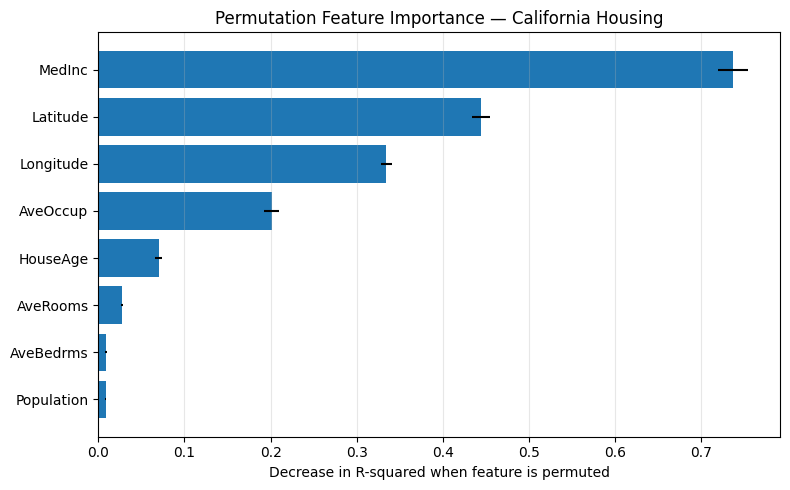

In [9]:
# Bar plot of mean drop ± std
imp_df = drop_table.copy().sort_values("Drop in R-squared", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(imp_df["Feature"], imp_df["Drop in R-squared"], xerr=imp_df["Drop Std"])
plt.xlabel("Decrease in R-squared when feature is permuted")
plt.title("Permutation Feature Importance — California Housing")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# The code for generating this plot was taken from Chatgpt-5 on 10/19/2025

The bars represent the drop in model performance (R²) when each feature is shuffled, while the black error bars represent the standard deviation (std) of that R-squared drop across the 20 random shuffles.

Together, these results mirror what we saw in the table:
Income and location explain most of the model’s predictive power, while structural and demographic features like house age, rooms, and population play smaller roles.

This visualization essentially makes the impact of each feature immediately clear rather than looking at numbers in a tabular format.

TO summarize, Permutation Feature Importance (PFI) helps us move from simply knowing how well the model performs to understanding why it performs that way.

By measuring the drop in R-square when each feature was randomly shuffled, we uncovered which variables truly drive the Random Forest’s predictions.
The results showed that Median Income overwhelmingly determines housing prices, while Latitude and Longitude reveal regional price patterns across California.
Other factors such as the number of rooms, population, and house age have minor but contextual influence.

This exercise highlights one of the main strengths of explainable AI methods — they allow us to peek inside complex models and translate predictive power into interpretable insights.
Even though the model’s R-squares alone tells us it performs well, PFI explains what’s behind that performance, making our model not just accurate, but understandable.

It is important to note that Permutation Importance is model-agnostic, which means that it can be applied to any predictive model — from simple linear regressions to gradient-boosted trees or neural networks — without retraining or modifying the model itself.
Different evaluation metrics can be used depending on the task:
For regression, we can use metrics like R², Mean Absolute Error (MAE), or RMSE to see how sensitive the model is to each feature. While, for classification, metrics such as Accuracy, F1-score, or ROC-AUC can help us understand which features most influence the model’s ability to distinguish between classes.

Thus, exploring PFI across multiple models and metrics not only validates which patterns are consistent but also reveals how each algorithm “sees” the data differently adn thus helps provide a view of model behavior and trustworthiness.